In [1]:
from data import loadData, preprocess, postprocess
from model import fft, lstm
from evaluate import evaluateModel, evaluateProfit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import matplotlib.patches as patches
from scipy.sparse import *

In [2]:
stock_name = "^GSPC"
date_predict_start = '2015-01-01'
window_length = 400
slide_range = 20
total_windows = 10

pv_range = 7
profit_percentage = 0.08
loss_percentage = 0.08

n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'

x_length = 180
y_length = 20
slide = y_length

epochs = 1
input_num = 6

In [3]:
dataloader = loadData.LoadData(stock_name, window_length, slide_range, total_windows, input_num)
train_data, test_data, train_data_index, test_data_index, all_data =\
    dataloader.load_and_split_data(date_predict_start)
all_data_index = all_data.index

c:\Users\e4903\Desktop\code\2023_hw\stock_predict\data\loadData.py:71: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  valid_date = all_data.index.asof(date_predict_start)


In [4]:
preprocesser = preprocess.Preprocess(x_length, y_length)
x_train, y_train, scaler =\
    preprocesser.preprocess_train_data(train_data)
x_train, y_train = preprocesser.shuffle(x_train, y_train)
x_test, y_test =\
    preprocesser.preprocess_test_data(train_data, test_data)

In [5]:
model = lstm.Lstm()
lstm_processed_signal, history, evaluate = model.lstm(x_train, y_train, x_test, y_test, test_data, y_length, epochs)

5/5 [==============================] - 5s 1s/step - loss: 0.0843 - val_loss: 0.0291


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 211ms/step - loss: 0.0208


 10%|█         | 1/10 [00:01<00:17,  1.98s/it]

1/1 [==============================] - 0s 209ms/step - loss: 0.0196


 20%|██        | 2/10 [00:02<00:09,  1.14s/it]

1/1 [==============================] - 0s 199ms/step - loss: 0.0206


 30%|███       | 3/10 [00:03<00:05,  1.19it/s]

1/1 [==============================] - 0s 190ms/step - loss: 0.0217


 40%|████      | 4/10 [00:03<00:04,  1.45it/s]

1/1 [==============================] - 0s 202ms/step - loss: 0.0222


 50%|█████     | 5/10 [00:03<00:03,  1.60it/s]

1/1 [==============================] - 0s 187ms/step - loss: 0.0200


 60%|██████    | 6/10 [00:04<00:02,  1.75it/s]

1/1 [==============================] - 0s 195ms/step - loss: 0.0217


 70%|███████   | 7/10 [00:04<00:01,  1.85it/s]

1/1 [==============================] - 0s 186ms/step - loss: 0.0190


 80%|████████  | 8/10 [00:05<00:01,  1.94it/s]

1/1 [==============================] - 0s 204ms/step - loss: 0.0208


 90%|█████████ | 9/10 [00:05<00:00,  1.98it/s]

1/1 [==============================] - 0s 204ms/step - loss: 0.0228


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


In [6]:
post = postprocess.Postprocess()
pv_x_train = post.find_data_pv(x_train[:,:,:,0].reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2]), pv_range)
pv_x_train = pv_x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = np.concatenate((x_train, pv_x_train), axis=-1)
pv_x_test = post.find_data_pv(x_test[:,:,:,0].reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2]), pv_range)
pv_x_test = pv_x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = np.concatenate((x_test, pv_x_test), axis=-1)
processed_signal = post.postprocess_lstm(lstm_processed_signal, scaler)
pv_train_data = post.find_data_pv(train_data[:,:,3], pv_range)
pv_test_data = post.find_data_pv(test_data[:,:,3], pv_range)
pv_signal = post.find_data_pv(processed_signal, pv_range)
lead_train = post.find_lead(pv_train_data, pv_signal)
lead_test = post.find_lead(pv_test_data, pv_signal)
first_date, lead, pv = post.get_first_lead(pv_signal, lead_test)

In [7]:
best_fit_harm = None
best_fit_error = None

In [8]:
evaluater = evaluateModel.Evaluate()

In [9]:
result_table = evaluater._built_result_table(
    processed_signal, test_data_index, lead, pv, best_fit_harm, best_fit_error)
result_table

,s_date,t_date,lead,ans_date,pv,best_fit,error
0,2014-12-31,NaN,6,NaN,valley,NaN,NaN
1,2015-01-30,NaN,-4,NaN,valley,NaN,NaN
2,2015-03-02,NaN,2,NaN,valley,NaN,NaN
3,2015-03-30,NaN,-3,NaN,valley,NaN,NaN
4,2015-04-28,NaN,1,NaN,valley,NaN,NaN
5,2015-05-27,NaN,4,NaN,valley,NaN,NaN
6,2015-06-24,NaN,1,NaN,valley,NaN,NaN
7,2015-07-23,NaN,-5,NaN,valley,NaN,NaN
8,2015-08-20,NaN,-5,NaN,valley,NaN,NaN
9,2015-09-18,NaN,-3,NaN,peak,NaN,NaN


In [10]:
evaluater._result_table_process(result_table, all_data_index, first_date)
result_table

,s_date,t_date,lead,ans_date,pv,best_fit,error
0,2014-12-31,2015-01-08,6,2015-01-16,valley,NaN,NaN
1,2015-01-30,2015-02-06,-4,2015-02-02,valley,NaN,NaN
2,2015-03-02,2015-03-09,2,2015-03-11,valley,NaN,NaN
3,2015-03-30,2015-04-07,-3,2015-04-01,valley,NaN,NaN
4,2015-04-28,2015-05-05,1,2015-05-06,valley,NaN,NaN
5,2015-05-27,2015-06-03,4,2015-06-09,valley,NaN,NaN
6,2015-06-24,2015-07-06,1,2015-07-07,valley,NaN,NaN
7,2015-07-23,2015-08-03,-5,2015-07-27,valley,NaN,NaN
8,2015-08-20,2015-08-31,-5,2015-08-24,valley,NaN,NaN
9,2015-09-18,2015-09-24,-3,2015-09-21,peak,NaN,NaN


In [11]:
average_lead = evaluater._compute_average_lead(result_table)

In [12]:
evaluater = evaluateModel.Evaluate()
result_table, average_lead = evaluater.evaluate_model(processed_signal, all_data_index, test_data_index, best_fit_harm, best_fit_error, first_date, lead, pv)
print('average_lead = ', average_lead)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(result_table)

average_lead =  3.4


,s_date,t_date,lead,ans_date,pv,best_fit,error
0,2014-12-31,2015-01-08,6,2015-01-16,valley,NaN,NaN
1,2015-01-30,2015-02-06,-4,2015-02-02,valley,NaN,NaN
2,2015-03-02,2015-03-09,2,2015-03-11,valley,NaN,NaN
3,2015-03-30,2015-04-07,-3,2015-04-01,valley,NaN,NaN
4,2015-04-28,2015-05-05,1,2015-05-06,valley,NaN,NaN
5,2015-05-27,2015-06-03,4,2015-06-09,valley,NaN,NaN
6,2015-06-24,2015-07-06,1,2015-07-07,valley,NaN,NaN
7,2015-07-23,2015-08-03,-5,2015-07-27,valley,NaN,NaN
8,2015-08-20,2015-08-31,-5,2015-08-24,valley,NaN,NaN
9,2015-09-18,2015-09-24,-3,2015-09-21,peak,NaN,NaN


In [13]:
evaluater = evaluateProfit.EvaluateProfit()

In [14]:
total_profit, profit_table = evaluater.build_profit_table_strategy_1(result_table, all_data, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)

total_profit = 1.0604248046875


,in_date,in_price,out_date,out_price,pv,profit,profitability
0,2015-01-08,2030.61,2015-01-20,2022.55,valley,-8.06,-0.004 %
1,2015-02-06,2062.28,2015-02-18,2099.68,valley,37.4,0.0181 %
2,2015-03-09,2072.25,2015-03-18,2099.5,valley,27.25,0.0131 %
3,2015-04-07,2080.79,2015-04-16,2104.99,valley,24.2,0.0116 %
4,2015-05-05,2112.63,2015-05-14,2121.1,valley,8.47,0.004 %
5,2015-06-03,2110.64,2015-06-12,2094.11,valley,-16.53,-0.0078 %
6,2015-07-06,2073.95,2015-07-15,2107.4,valley,33.45,0.0161 %
7,2015-08-03,2104.49,2015-08-12,2086.05,valley,-18.44,-0.0088 %
8,2015-08-31,1986.73,2015-09-10,1952.29,valley,-34.44,-0.0173 %
9,2015-09-24,1934.81,2015-10-05,1987.05,peak,-52.24,-0.027 %


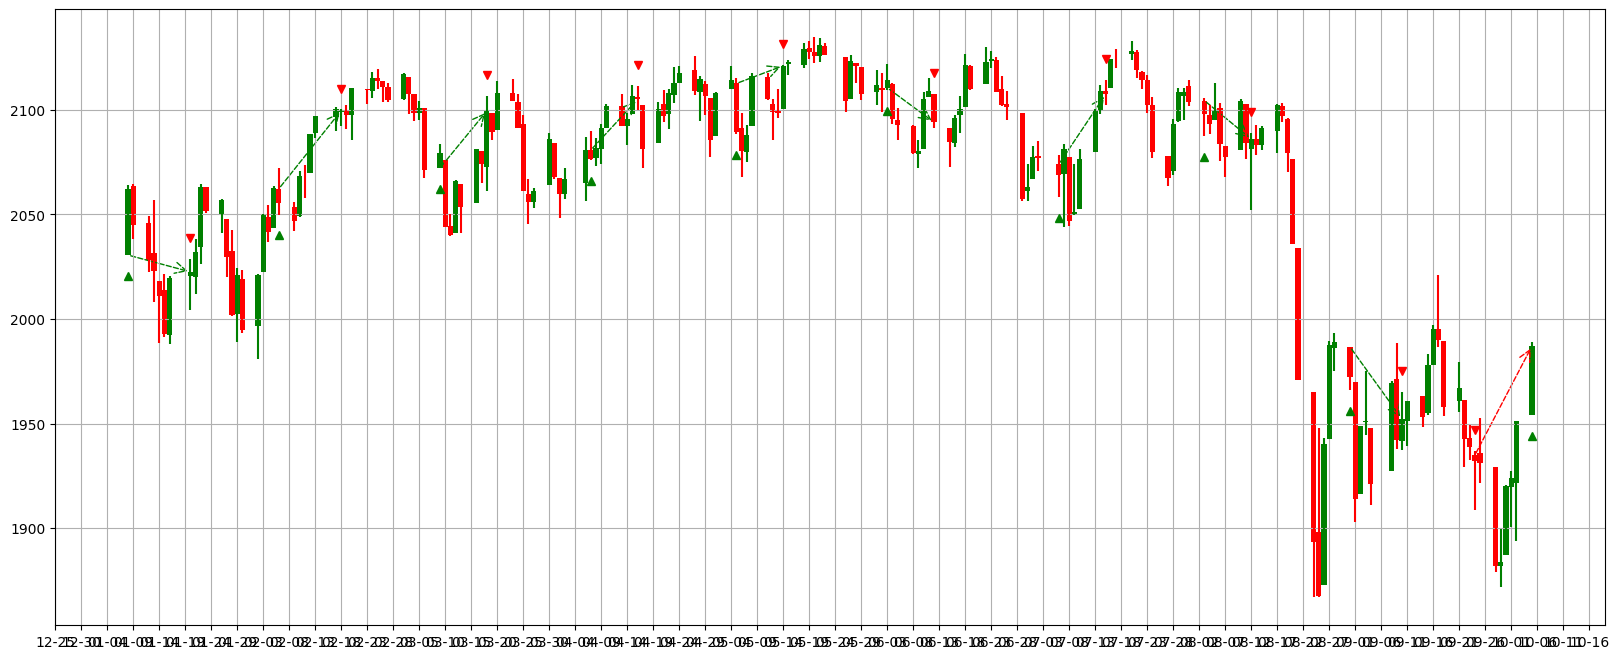

In [15]:
evaluater.draw_profit_plot(profit_table, all_data)

In [16]:
total_profit, profit_table = evaluater.build_profit_table_strategy_2(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)

total_profit = 1.0604248046875


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2015-01-08,2030.61,2015-01-20,2022.55,valley,-8.06,NaN,NaN,-0.004 %
1,2015-02-06,2062.28,2015-02-18,2099.68,valley,37.4,NaN,NaN,0.0181 %
2,2015-03-09,2072.25,2015-03-18,2099.5,valley,27.25,NaN,NaN,0.0131 %
3,2015-04-07,2080.79,2015-04-16,2104.99,valley,24.2,NaN,NaN,0.0116 %
4,2015-05-05,2112.63,2015-05-14,2121.1,valley,8.47,NaN,NaN,0.004 %
5,2015-06-03,2110.64,2015-06-12,2094.11,valley,-16.53,NaN,NaN,-0.0078 %
6,2015-07-06,2073.95,2015-07-15,2107.4,valley,33.45,NaN,NaN,0.0161 %
7,2015-08-03,2104.49,2015-08-12,2086.05,valley,-18.44,NaN,NaN,-0.0088 %
8,2015-08-31,1986.73,2015-09-10,1952.29,valley,-34.44,NaN,NaN,-0.0173 %
9,2015-09-24,1934.81,2015-10-05,1987.05,peak,-52.24,NaN,NaN,-0.027 %


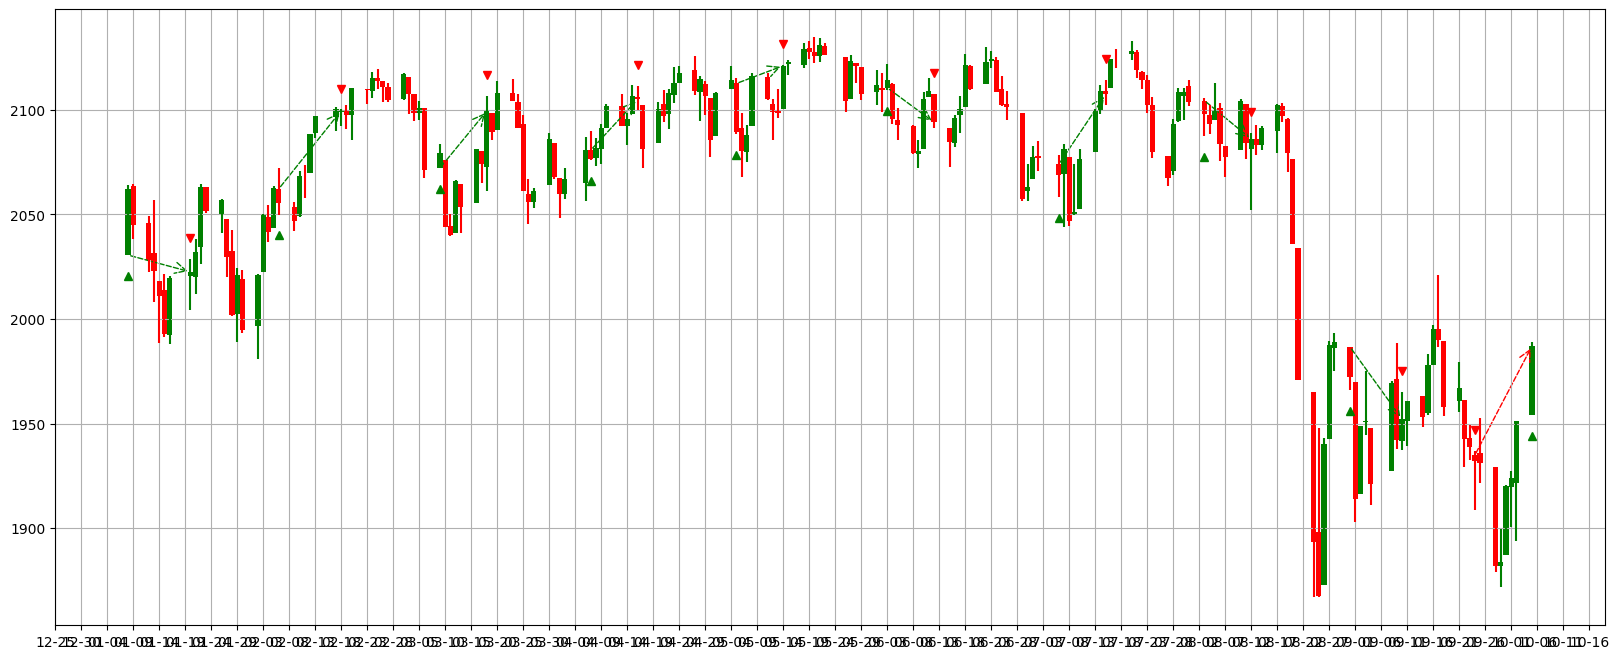

In [17]:
evaluater.draw_profit_plot(profit_table, all_data)

In [18]:
total_profit, profit_table = evaluater.build_profit_table_strategy_3(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)

total_profit = 1.0604248046875


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2015-01-08,2030.61,2015-01-20,2022.55,valley,-8.06,NaN,NaN,-0.004 %
1,2015-02-06,2062.28,2015-02-18,2099.68,valley,37.4,NaN,NaN,0.0181 %
2,2015-03-09,2072.25,2015-03-18,2099.5,valley,27.25,NaN,NaN,0.0131 %
3,2015-04-07,2080.79,2015-04-16,2104.99,valley,24.2,NaN,NaN,0.0116 %
4,2015-05-05,2112.63,2015-05-14,2121.1,valley,8.47,NaN,NaN,0.004 %
5,2015-06-03,2110.64,2015-06-12,2094.11,valley,-16.53,NaN,NaN,-0.0078 %
6,2015-07-06,2073.95,2015-07-15,2107.4,valley,33.45,NaN,NaN,0.0161 %
7,2015-08-03,2104.49,2015-08-12,2086.05,valley,-18.44,NaN,NaN,-0.0088 %
8,2015-08-31,1986.73,2015-09-10,1952.29,valley,-34.44,NaN,NaN,-0.0173 %
9,2015-09-24,1934.81,2015-10-05,1987.05,peak,-52.24,NaN,NaN,-0.027 %


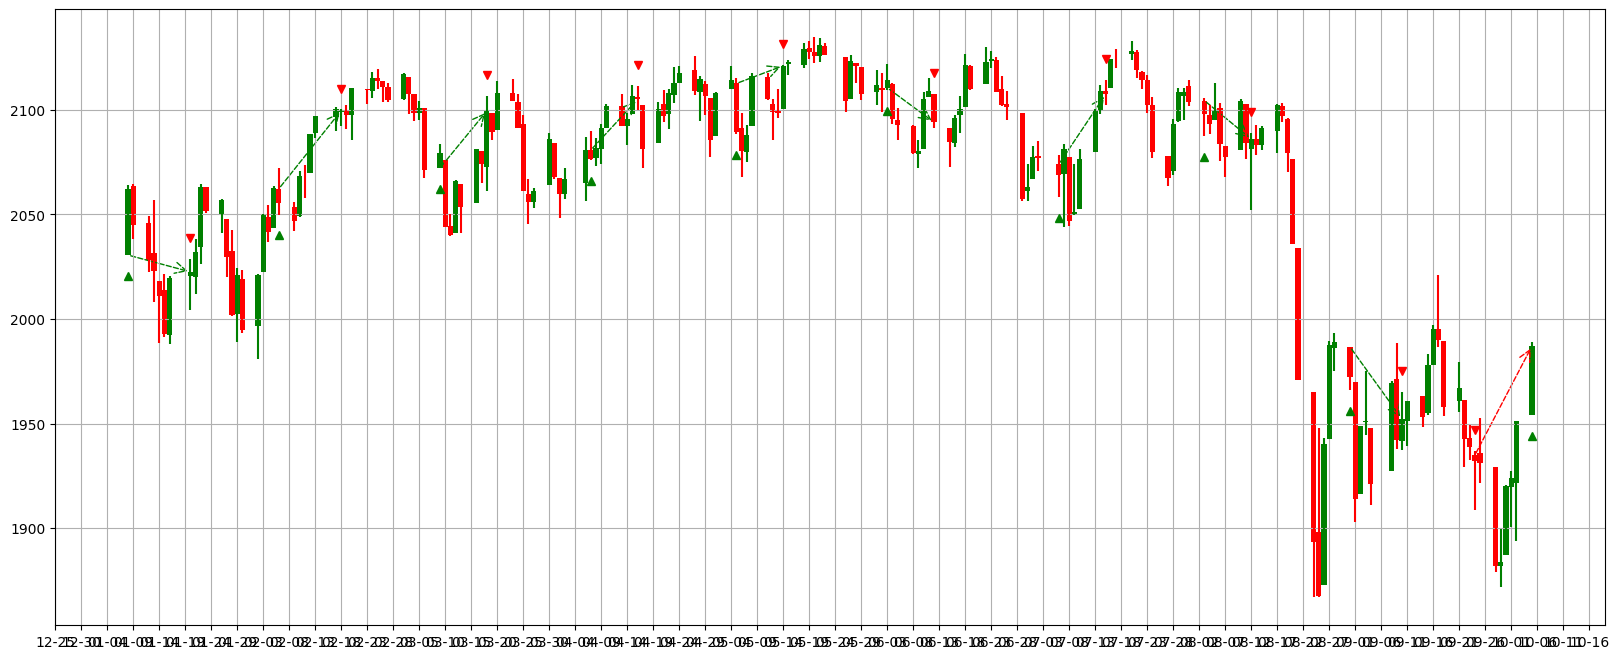

In [19]:
evaluater.draw_profit_plot(profit_table, all_data)

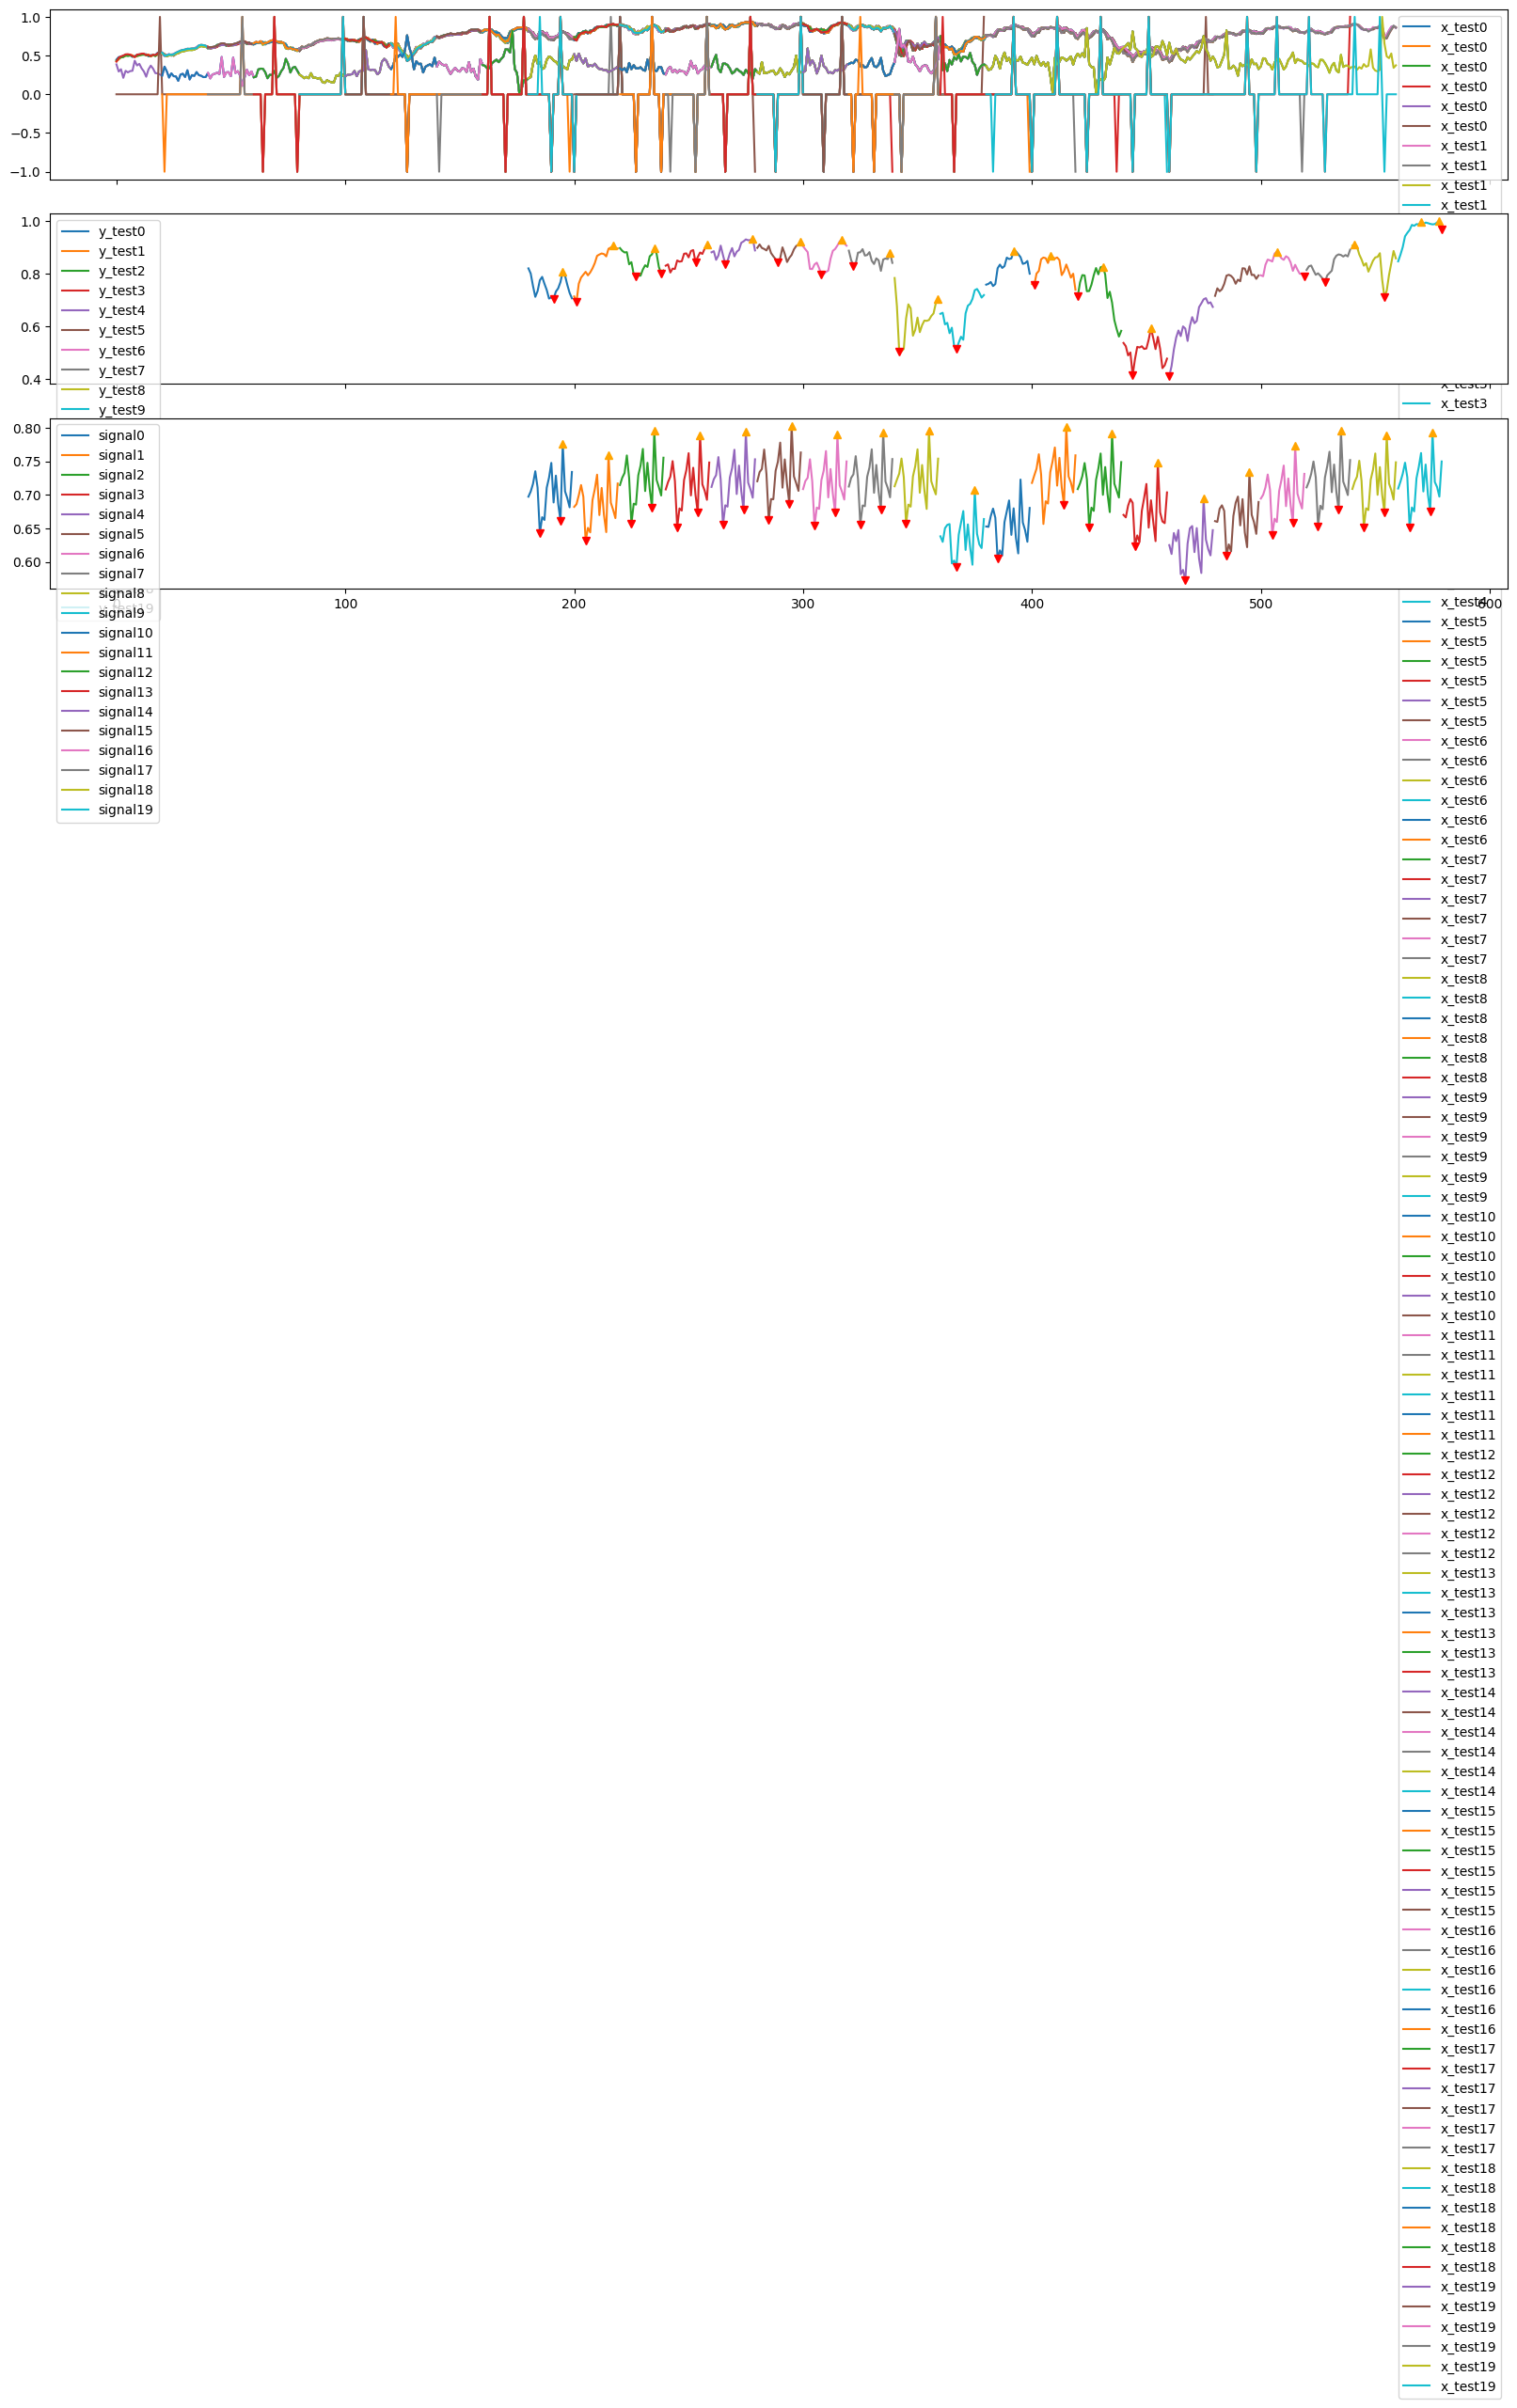

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(20, 8), sharex=True)
count=0
for i in range(0, x_test.shape[1]): 
    # print(i)
    countx=range(count, count+x_length)
    county=range(count+x_length, count+x_length+y_length)
    ax[0].plot(countx, x_test[0, i, :], label=f'x_test{i}')
    ax[1].plot(county, y_test[0, i], label=f'y_test{i}')
    ax[2].plot(county, lstm_processed_signal[0, i], label=f'signal{i}')
    count+=slide
for x , pv in enumerate(pv_test_data[0]):
    if pv == 1:
        ax[1].plot(x+x_length, y_test[0].flatten()[x], '^', color='orange')
    elif pv == -1:
        ax[1].plot(x+x_length, y_test[0].flatten()[x], 'v', color='red')
for x , pv in enumerate(pv_signal[0]):
    if pv == 1:
        ax[2].plot(x+x_length, lstm_processed_signal[0].flatten()[x], '^', color='orange')
    elif pv == -1:
        ax[2].plot(x+x_length, lstm_processed_signal[0].flatten()[x], 'v', color='red')
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

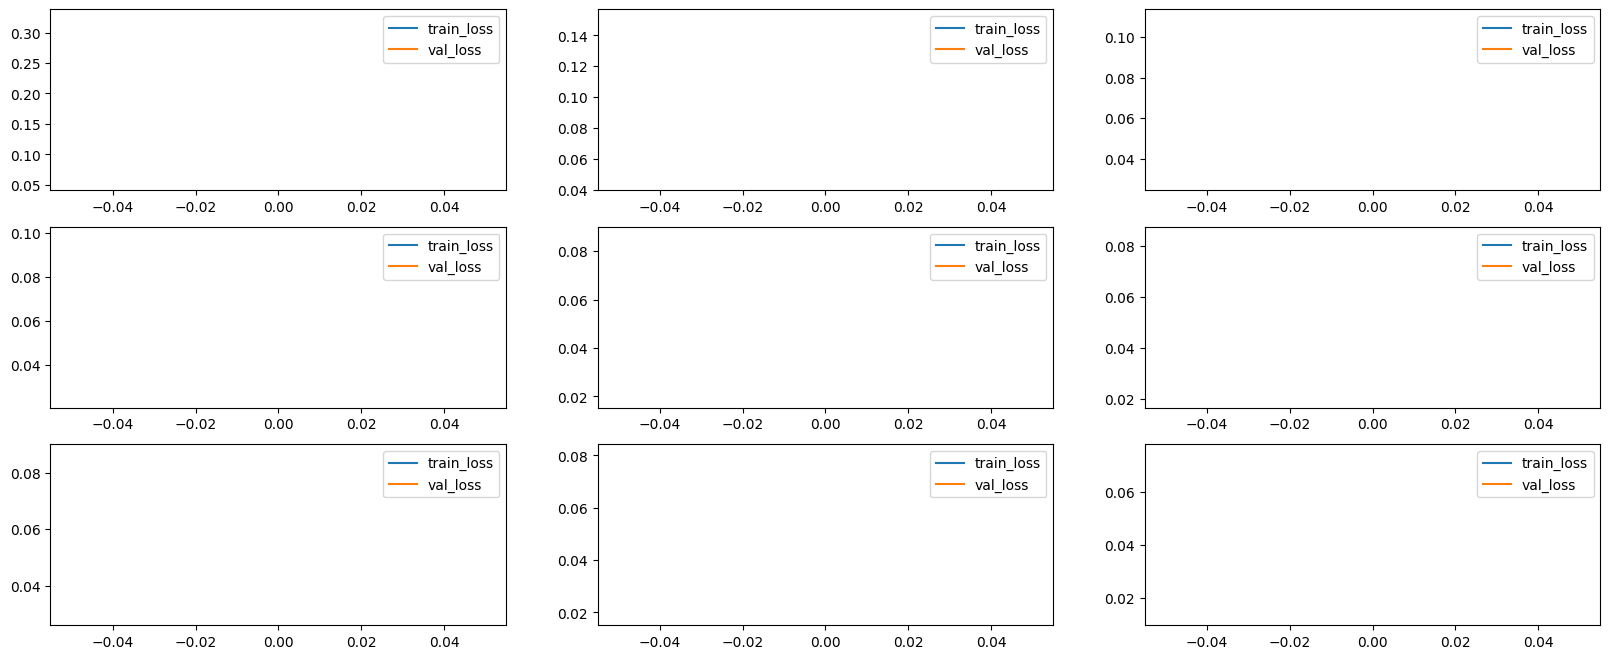

In [21]:
fig, ax = plt.subplots(3, 3, figsize=(20, 8))
i=0
for window in range(9):
    # visualizing losses and accuracy
    train_loss = history[window].history['loss']
    val_loss   = history[window].history['val_loss']
    # plt.title(f'window{window}')
    ax[i//3, i%3].plot(train_loss, label='train_loss')
    ax[i//3, i%3].plot(val_loss, label='val_loss')
    ax[i//3, i%3].legend()
    i+=1
plt.show()


In [22]:
def compute_rmse(predict_value, actual_value):
    absolute_error = np.abs(predict_value - actual_value)
    rmse = np.sqrt(np.mean(absolute_error**2))
    return rmse

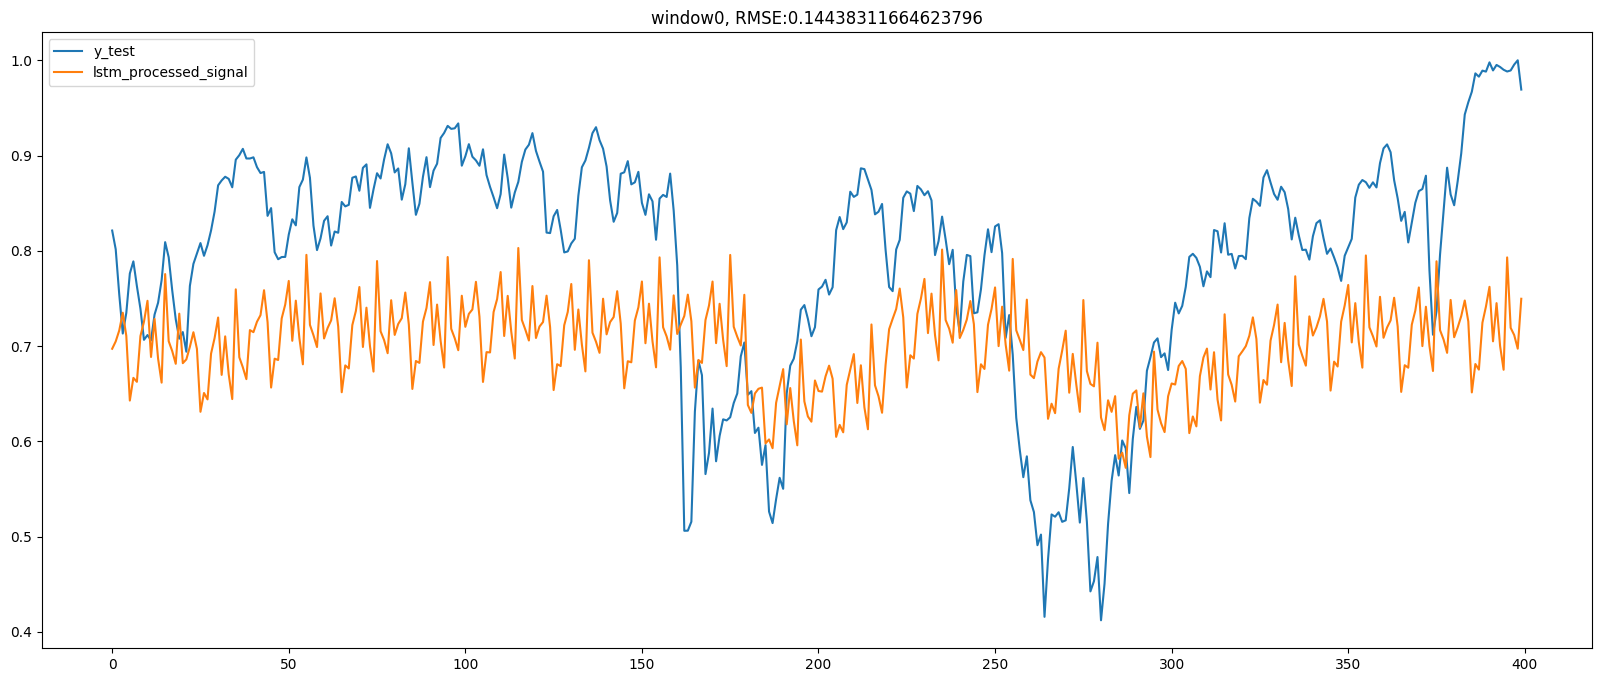

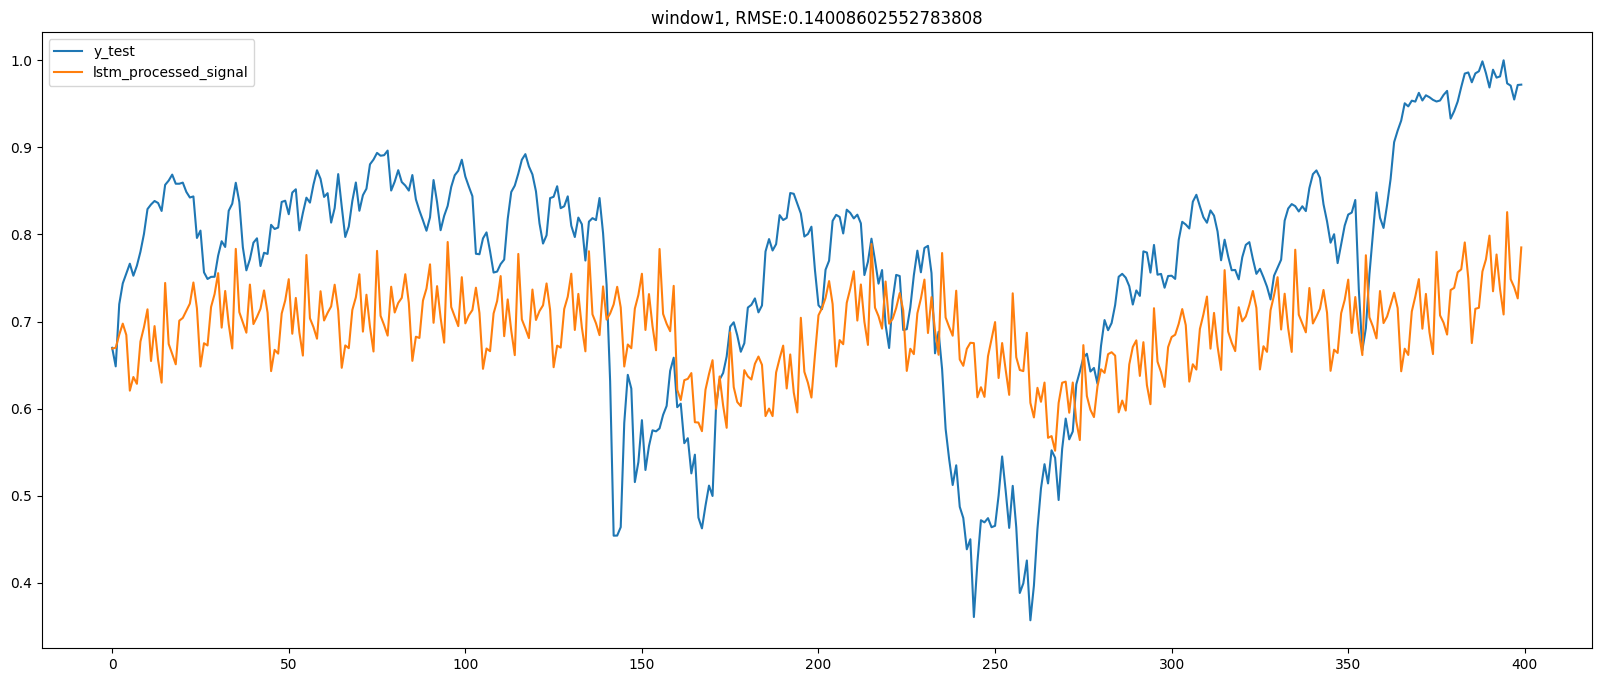

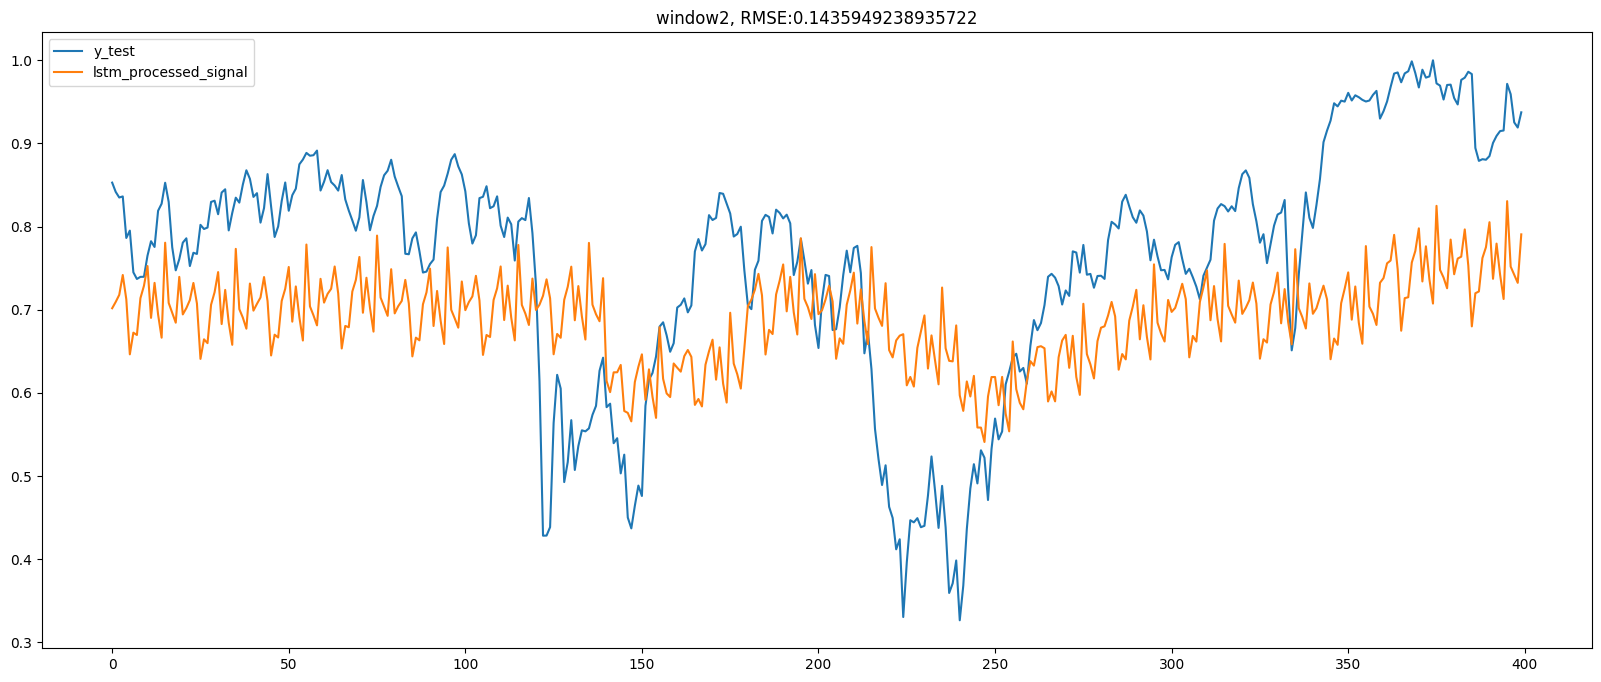

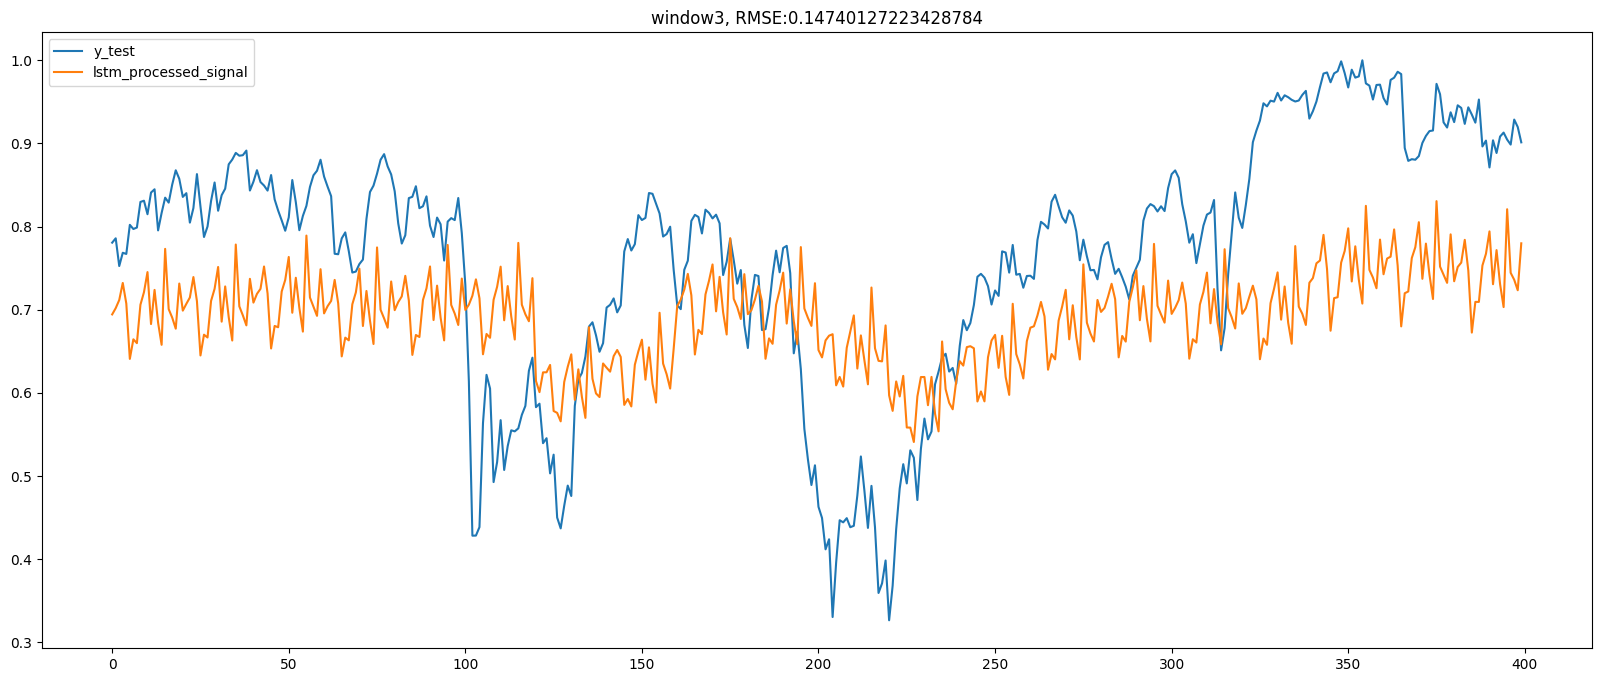

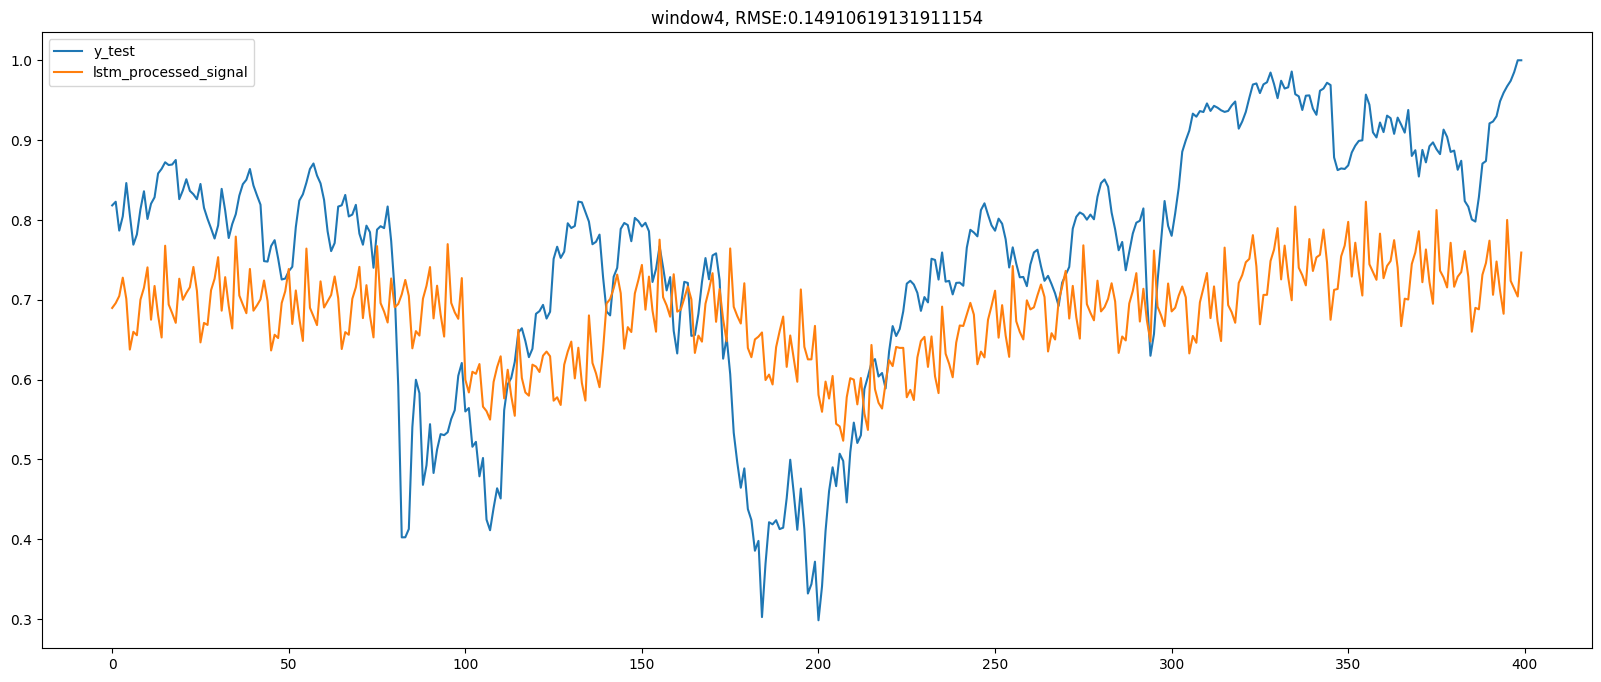

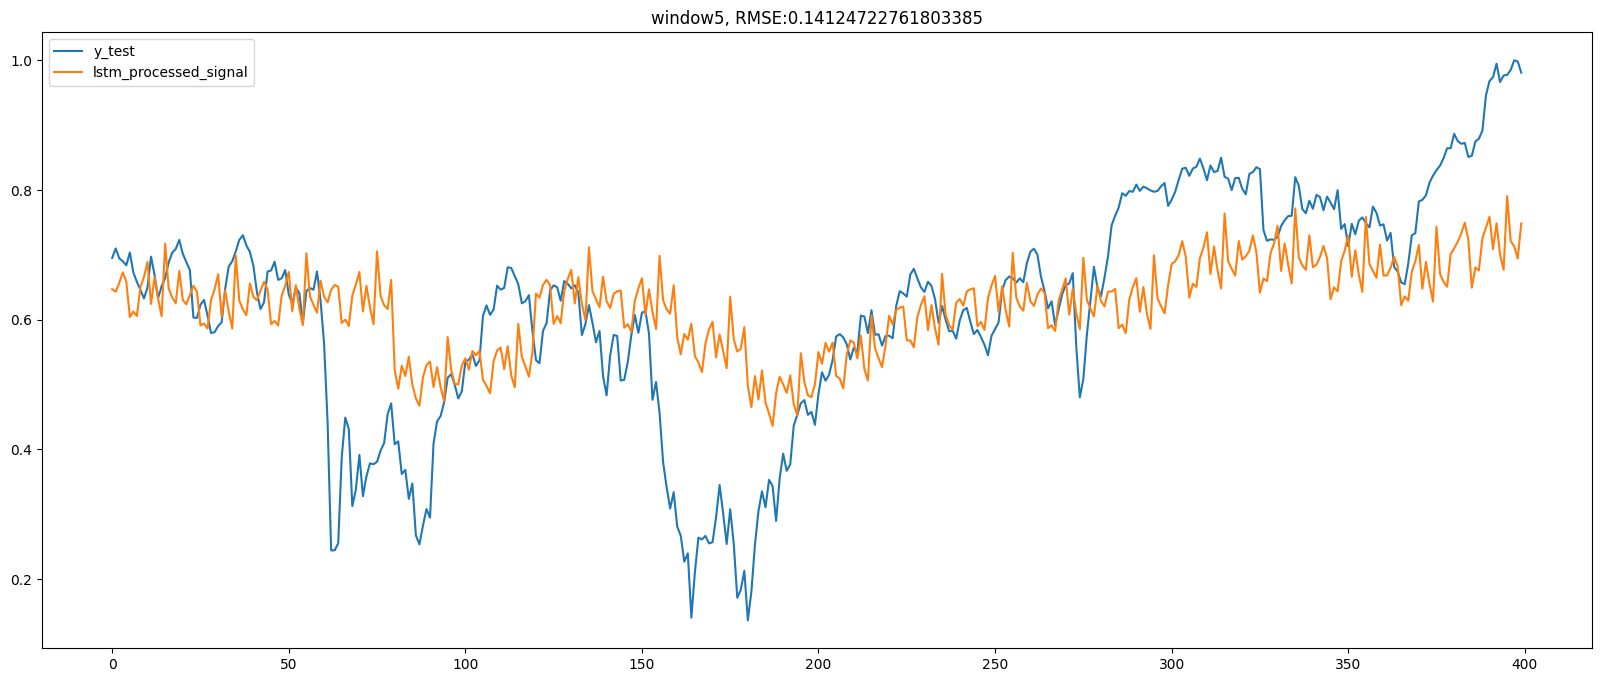

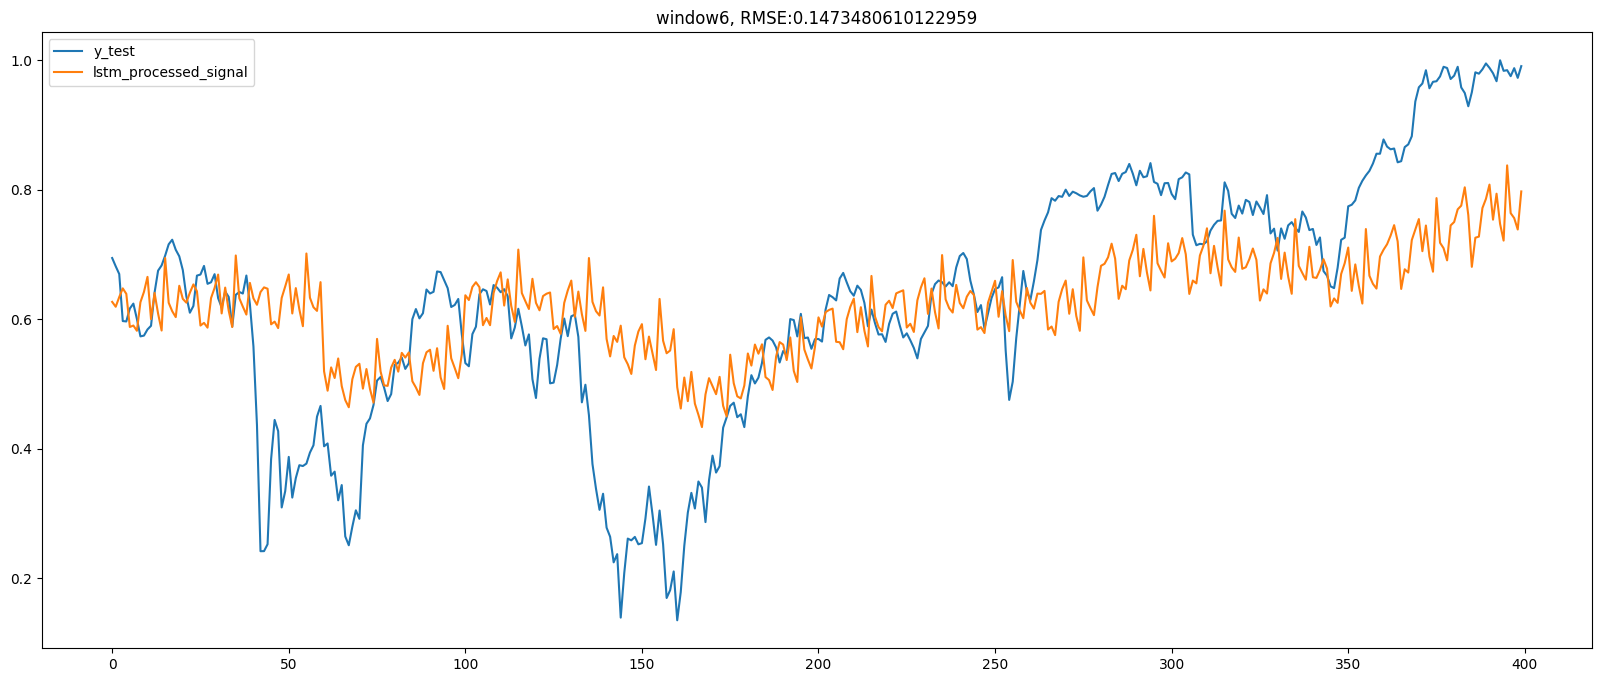

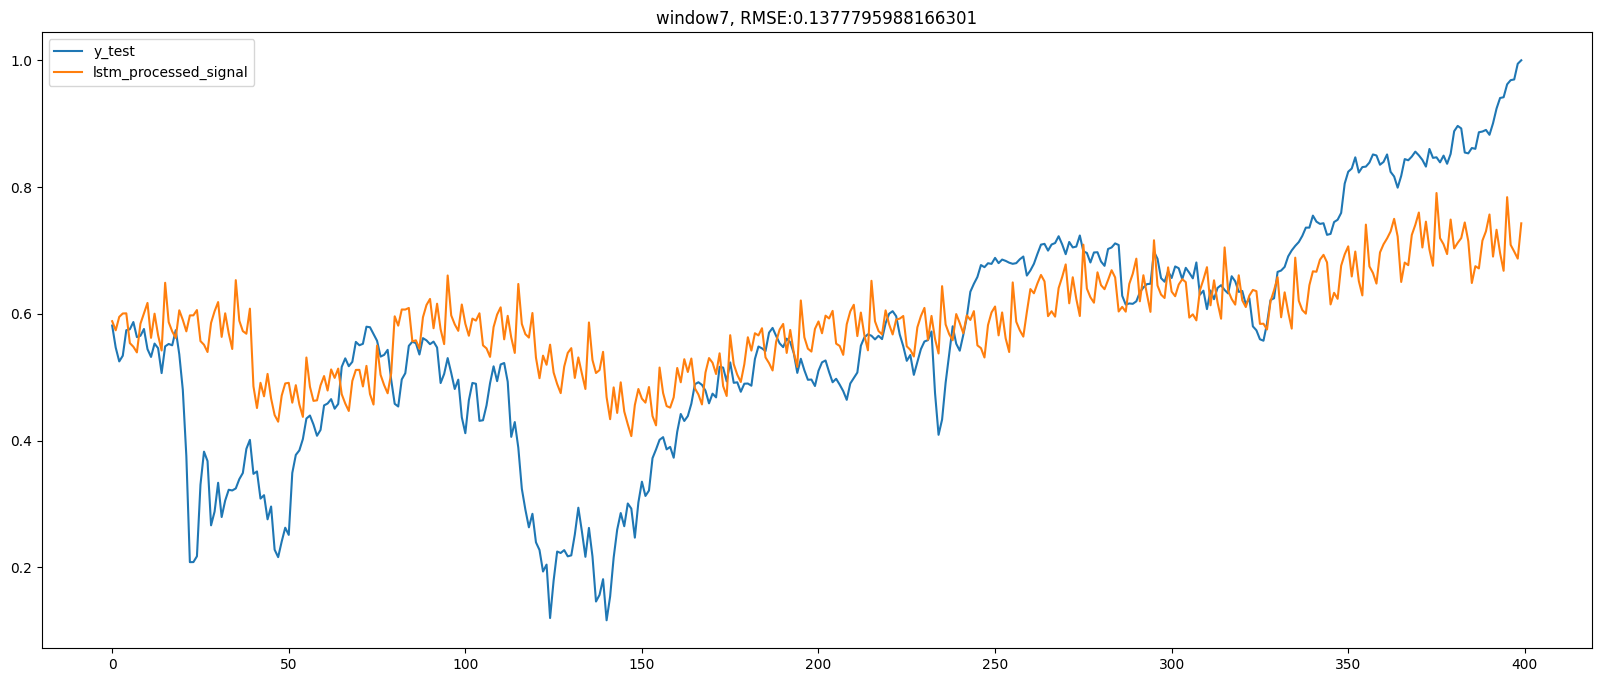

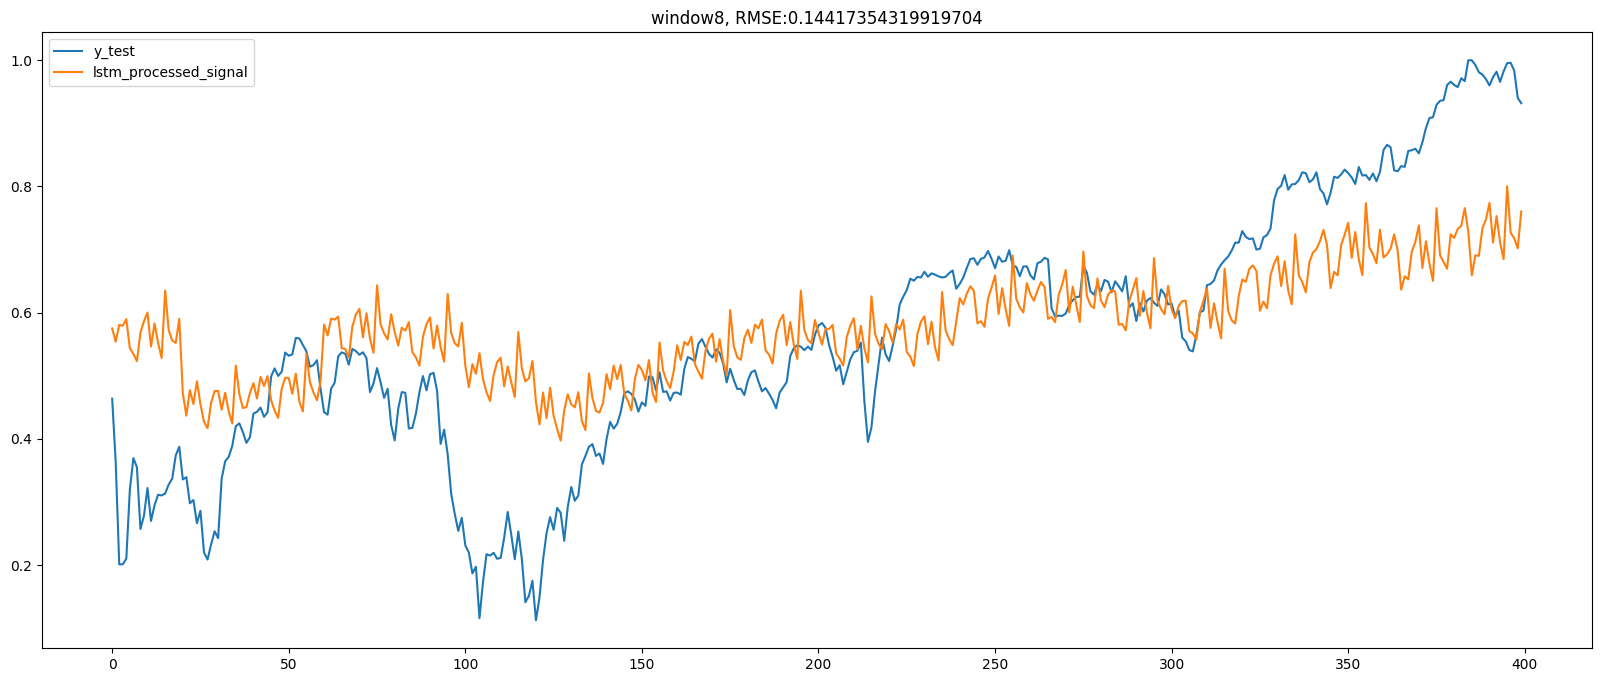

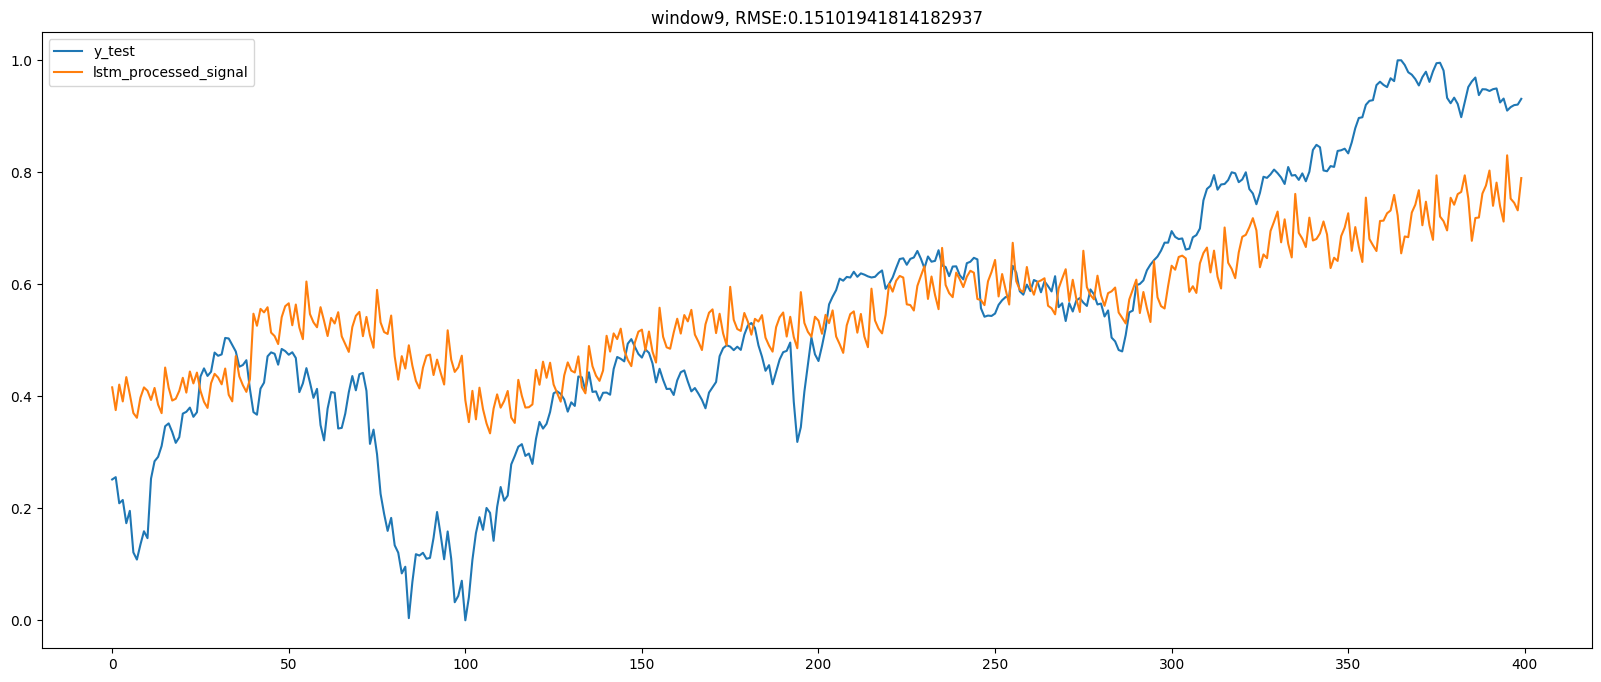

average_rmse=0.1446139378409034


In [23]:
rmse_list = list()
for window in range(test_data.shape[0]):
    RMSE = compute_rmse(lstm_processed_signal[window].flatten(), y_test[window].flatten())
    rmse_list.append(RMSE)
    plt.figure(figsize=(20, 8))
    plt.title(f'window{window}, RMSE:{RMSE}')
    plt.plot(y_test[window].flatten(), label='y_test')
    plt.plot(lstm_processed_signal[window].flatten(), label='lstm_processed_signal')
    plt.legend()
    plt.show()
average_rmse = sum(rmse_list) / len(rmse_list)
print(f'average_rmse={average_rmse}')